<a href="https://colab.research.google.com/github/Zokoban/pyOCRTEN/blob/Full_TensorFlow/Image_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data preprocessing

In [2]:
#@title setting up the google drive

from google.colab import drive

drive.mount("/drive")

Mounted at /drive


In [3]:
#@title Download all data on the drive
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

y


In [4]:
#@title Load all the required packages
import pandas as pd
import numpy as np
import csv
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [5]:
#@title Load word.txt file
#############
# Variables #
#############

path_to_txt = "data/words.txt"

#--------------------------------------

#########################
# Function get_word_txt #
#########################

def get_word_txt(path_to_txt):
  word_txt=pd.read_csv(path_to_txt, 
                      sep=' ', 
                      names=["word_id","segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","transcription_1","transcription_2","transcription_3"], 
                      quoting=csv.QUOTE_NONE, 
                      skiprows=18, 
                      on_bad_lines="warn")

  def f(x):
      if x == "nan":
          return ""
      else:
          return x
  word_txt["transcription"]=word_txt.transcription_1.astype("str")+\
                            word_txt.transcription_2.astype("str").apply(f)+\
                            word_txt.transcription_3.astype("str").apply(f)
  word_txt=word_txt.drop(columns=["transcription_1","transcription_2","transcription_3"])

  def f(x):
      return len(x)

  word_txt["number_components"]=word_txt.transcription.apply(f)

  

  return word_txt

#----------------------------------------------------------

word_txt = get_word_txt(path_to_txt)

print("word_txt Length: ",len(word_txt))
word_txt.head()

word_txt Length:  115320


,word_id,segmentation_result,gray_level,x,y,pxw,pxh,grammatical_tag,transcription,number_components
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,1
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,4
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,2
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,4
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,3


In [48]:
#@title Choice of the fraction of the dataset / Removal of Transcription error / Removal of unwanted column

#############
# Variables #
#############

fraction = 1
data_dir = "data/words/"
image_extensions = [".png"]  # add there all your images file extensions
img_type_accepted_by_tf = ["png"]
random_state = 4321

#--------------------------------------------------------------------------
from pathlib import Path
import imghdr

def img_path(word):
    path=data_dir+word.split("-")[0]+"/"+word.split("-")[0]+"-"+word.split("-")[1]+"/"+word+".png"
    
    return path

def removal_of_corrupt_image(df):
  index_to_drop=[]
  for filepath in Path(data_dir).rglob("*"):
      if filepath.suffix.lower() in image_extensions:
          img_type = imghdr.what(filepath)
          if img_type is None:
              index_to_drop.append(df[df.filepath==str(filepath)].index)
              df=df.drop(labels=df[df.filepath==str(filepath)].index)
              print(f"{filepath} is not an image")
          elif img_type not in img_type_accepted_by_tf:
              df=df.drop(labels=df[df.filepath==str(filepath)].index)
              print(f"{filepath} is a {img_type}, not accepted by TensorFlow and is drop")
  return df

def word_txt_cleaning(word_txt,fraction,random_state=None):

  if random_state==None:
    random_state=np.random.randint(10000)

  list_columns_to_remove=["segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","number_components"]

  df = word_txt[word_txt.segmentation_result == "ok"]\
      .drop(columns=list_columns_to_remove)\
      .sample(frac=fraction,random_state=random_state)

  df["filepath"]=df.word_id.apply(img_path)
  df=removal_of_corrupt_image(df)

  return df

#------------------------------------------------------------------

##################################
#   Removal of unwanted Column   #
#   And removal of corrupt image #
##################################


df = word_txt_cleaning(word_txt,fraction,random_state)

df.head()

data/words/r06/r06-022/r06-022-03-05.png is not an image
data/words/a01/a01-117/a01-117-05-02.png is not an image


,word_id,transcription,filepath
58546,g06-011o-03-13,",",data/words/g06/g06-011o/g06-011o-03-13.png
79980,j04-111-07-02,.,data/words/j04/j04-111/j04-111-07-02.png
95482,m04-019-02-11,is,data/words/m04/m04-019/m04-019-02-11.png
111838,r02-127-01-03,who,data/words/r02/r02-127/r02-127-01-03.png
62790,g06-031r-05-04,dissolution,data/words/g06/g06-031r/g06-031r-05-04.png


## Preaparation of dataset, Loading + Preprocessing of the image and Vectorization of the labels

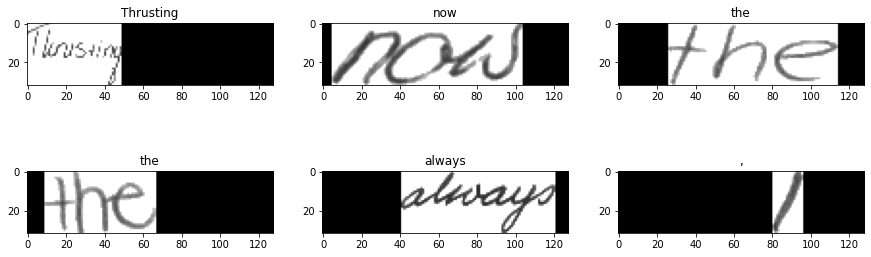

In [49]:
#@title Loading and preprocessing of images

#############
# Variables #
#############

batch_size = 64
image_width=128
image_height=32
imgSize = (image_height, image_width)

random_state=np.random.randint(10000)
train_size=0.8
validation_size=0.5
#-----------------------------------

###############################################################
# Definition of functions:                                    #
#     - Loading images                                        #
#     - Preprocessing of images (resizing without distortion) #
###############################################################

import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

#Loading function of images (with tensorflow)
@tf.function
def load_image(filepath):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=0)

    return im

#Preprocessing function of images (with tensorflow)
@tf.function
def preprocess(filepath, imgSize=(32, 128), dataAugmentation=False, scale=0.8, isthreshold=False):



    img = load_image(filepath)/255
    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = tf.ones([imgSize[0], imgSize[1], 1])
        print("None")

    if dataAugmentation:
        stretch = scale*(tf.random.uniform([1], 0, 1)[0] - 0.3) # -0.5 .. +0.5
        wStretched = tf.maximum(int(float(tf.shape(img)[0]) * (1 + stretch)), 1) # random width, but at least 1
        img = tf.image.resize(img, (wStretched, tf.shape(img)[1])) # stretch horizontally by factor 0.5 .. 1.5

    (wt, ht) = imgSize

    w, h = float(tf.shape(img)[0]), float(tf.shape(img)[1])

    fx = w / wt
    fy = h / ht

    f = tf.maximum(fx, fy)

    newSize = (tf.maximum(tf.minimum(wt, int(w / f)), 1), tf.maximum(tf.minimum(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)

    img = tf.image.resize(img, newSize)


    dx = wt - newSize[0]
    dy = ht - newSize[1]

    if dataAugmentation :
        dx1=0
        dy1=0
        if dx!=0:
            dx1 = tf.random.uniform([1], 0, dx, tf.int32)[0]
        if dy!=0:
            dy1 = tf.random.uniform([1], 0, dy, tf.int32)[0]
        img = tf.pad(img[..., 0], [[dx1, dx-dx1], [dy1, dy-dy1]], constant_values=0)
    else :
        img = tf.pad(img[..., 0], [[0, dx], [0, dy]], constant_values=0)

    if isthreshold:
        return tf.expand_dims(1-(1-img)*tf.cast(img < 0.8, tf.float32), -1)
    return tf.expand_dims(img, -1)

def create_dataset(X_path,y_label,y_id,batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((X_path, y_label,y_id))
  dataset = dataset.shuffle(10000)\
                  .map(lambda x, y,z : [preprocess(x, imgSize, dataAugmentation=True, scale=0.8, isthreshold=True), y,z])\
                  .batch(batch_size, drop_remainder=True)
  return dataset
#-----------------------------------------------------------------------------

####################
# Creation dataset #
####################


dataset = create_dataset(df.filepath.values, df.transcription.values,df.word_id,batch_size)
#-----------------------------------------------------------------------------

################################################
# Iteration on dataset_train                   #
# Display of several images from train dataset #
################################################

X_t, y_t, z_t = next(iter(dataset))

def display_image_from_tf_dataset(X_t,y_t):
  plt.figure(figsize=(15,5))
  for j, i in enumerate(np.random.randint(low=0, high=len(X_t), size=[6])):
      plt.subplot(2,3,j+1)
      plt.imshow(X_t[i][...,0], cmap='gray')
      plt.title(y_t[i].numpy().decode('utf'))

display_image_from_tf_dataset(X_t,y_t)

In [50]:
len(dataset)

1507

In [29]:
!mkdir preprocess_image


In [39]:
def save_image_from_tf(X_t,z_t,path):
  for i in range(len(X_t)):
    img=X_t[i][...,0].numpy()
    id = z_t[i].numpy().decode("utf-8")
    plt.imsave(path+id+".png", img)

In [51]:
path = "./preprocess_image/"
i=0
for X_t,y_t,z_t in dataset:
  i=i+1
  print("batch:",i,"on",len(dataset))
  print("---------------")
  save_image_from_tf(X_t,z_t,path)

batch: 1 on 1507
---------------
batch: 2 on 1507
---------------
batch: 3 on 1507
---------------
batch: 4 on 1507
---------------
batch: 5 on 1507
---------------
batch: 6 on 1507
---------------
batch: 7 on 1507
---------------
batch: 8 on 1507
---------------
batch: 9 on 1507
---------------
batch: 10 on 1507
---------------
batch: 11 on 1507
---------------
batch: 12 on 1507
---------------
batch: 13 on 1507
---------------
batch: 14 on 1507
---------------
batch: 15 on 1507
---------------
batch: 16 on 1507
---------------
batch: 17 on 1507
---------------
batch: 18 on 1507
---------------
batch: 19 on 1507
---------------
batch: 20 on 1507
---------------
batch: 21 on 1507
---------------
batch: 22 on 1507
---------------
batch: 23 on 1507
---------------
batch: 24 on 1507
---------------
batch: 25 on 1507
---------------
batch: 26 on 1507
---------------
batch: 27 on 1507
---------------
batch: 28 on 1507
---------------
batch: 29 on 1507
---------------
batch: 30 on 1507
-----

In [54]:
!cp  /preprocess_image.zip /drive/MyDrive/DataScience/OCR/data/preprocess_image.zip
